<a href="https://colab.research.google.com/github/csy99/dna-nn-theory/blob/master/lstm_(supervised)_chip(256_adam).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import re
import time
# from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras

In [2]:
!pip install biopython
from Bio import SeqIO

     |████████████████████████████████| 2.3MB 3.4MB/s 


# Read Data

In [3]:
!pip install PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
def readFasta(file):
  with open(file, 'r') as f:
    records = np.array([record.seq._data.upper() for record in SeqIO.parse(f, 'fasta')])
  with open(file, 'r') as f:
    records_id = np.array([record.id for record in SeqIO.parse(f, 'fasta')])
  print('reading', str(file), 'Number of sequences :', 
        len(records), 'Length of sequences :', len(records[0]))
  records_df = pd.DataFrame({'id': records_id, 'seq': records})
  return records_df

In [5]:
# read fasta data
data_path = '/content/gdrive/My Drive/Colab Notebooks/CHIP/'
chip_train = readFasta(data_path + 'train.fasta')
chip_val = readFasta(data_path + 'valid.fasta')
chip_test = readFasta(data_path + 'test.fasta')
chip_train["id"] = chip_train["id"].astype(int)
chip_val["id"] = chip_val["id"].astype(int)
chip_test["id"] = chip_test["id"].astype(int)
print(chip_train.id.value_counts())
print(chip_val.id.value_counts())
print(chip_test.id.value_counts())

reading /content/gdrive/My Drive/Colab Notebooks/CHIP/train.fasta Number of sequences : 77174 Length of sequences : 101
reading /content/gdrive/My Drive/Colab Notebooks/CHIP/valid.fasta Number of sequences : 1000 Length of sequences : 101
reading /content/gdrive/My Drive/Colab Notebooks/CHIP/test.fasta Number of sequences : 19544 Length of sequences : 101
1    38638
0    38536
Name: id, dtype: int64
1    500
0    500
Name: id, dtype: int64
0    9823
1    9721
Name: id, dtype: int64


In [ ]:
# seq_num = 0
# for seq in chip_train["seq"]:
#   char_num = 0
#   for char in seq:
#     if char != 'A' and char != 'C' and char != 'T' and char != 'G':
#       print("seq", seq_num, 'char', char_num, 'is', char)
#     char_num += 1
#   seq_num += 1

In [6]:
# check if the length of the sequence is the same 
seq_len = len(chip_train.seq[0])
print("The length of the sequence is", seq_len)
for seq in chip_train.seq[:200]:
  assert len(seq) == seq_len

The length of the sequence is 101


In [7]:
word_size = 1
vocab = [''.join(p) for p in product('ACGT', repeat=word_size)]
vocab_size = len('ACGT')
print('vocab_size:', vocab_size)
# print("word_to_idx", word_to_idx)
create1gram = keras.layers.experimental.preprocessing.TextVectorization(
  standardize=lambda x: tf.strings.regex_replace(x, '(.)', '\\1 '), ngrams=1
)
create1gram.adapt(vocab)

vocab_size: 4


In [19]:
# the first two index of TextVectorization has been reserved to EOS and OOV
def index_preprocess(x):
  x_index = tf.subtract(create1gram(x), 2)
  return x_index,x_index

In [20]:
def ds_preprocess(x, y):
  x_index = tf.subtract(create1gram(x), 2)
  return x_index, y

In [ ]:
# not sure the correct way to get mapping from word to its index
create1gram('A C G T') - 2

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 2, 1, 0])>

In [22]:
BATCH_SIZE = 256
xtrain_ds = tf.data.Dataset.from_tensor_slices((chip_train['seq'], chip_train['id'])).map(ds_preprocess).batch(BATCH_SIZE)
xval_ds = tf.data.Dataset.from_tensor_slices((chip_val['seq'], chip_val['id'])).map(ds_preprocess).batch(BATCH_SIZE)
xtest_ds = tf.data.Dataset.from_tensor_slices((chip_test['seq'], chip_test['id'])).map(ds_preprocess).batch(BATCH_SIZE)
# xtrain_seq = np.array(xtrain_seq)
# xval_seq = np.array(xval_seq)
# xtest_seq = np.array(xtest_seq)

In [10]:
latent_size = 30

model = keras.Sequential([
    keras.Input(shape=(seq_len,)),
    keras.layers.Embedding(seq_len, latent_size),
    keras.layers.LSTM(latent_size, return_sequences=False),
    keras.layers.Dense(128, activation="relu", input_shape=[latent_size]),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),    
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation="relu"),  
    keras.layers.Dropout(0.2), 
    keras.layers.Dense(16, activation="relu"), 
    keras.layers.Dropout(0.2),   
    keras.layers.Dense(1, activation="sigmoid")                               
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 101, 30)           3030      
_________________________________________________________________
lstm (LSTM)                  (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 128)               3968      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2

In [11]:
# save_freq=1500 means that the model will be saved around every 20 epochs (each epochs contain 76 batches)
checkpoint_filepath = '/content/gdrive/My Drive/Colab Notebooks/models/lstm_supervised_chip.256adam.{epoch:04d}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=False,
    save_freq=1500)
es_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [23]:
BATCH_SIZE = 256
model.compile(keras.optimizers.Adam(0.0005), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
hist = model.fit(xtrain_ds, validation_data=xval_ds, epochs=1000, callbacks=[es_cb, model_checkpoint_callback])

Epoch 1/1000
302/302 [==============================] - 16s 53ms/step - loss: 0.6814 - accuracy: 0.5533 - val_loss: 0.6693 - val_accuracy: 0.5870
Epoch 2/1000
302/302 [==============================] - 15s 51ms/step - loss: 0.6630 - accuracy: 0.6021 - val_loss: 0.6631 - val_accuracy: 0.5950
Epoch 3/1000
302/302 [==============================] - 15s 51ms/step - loss: 0.6600 - accuracy: 0.6040 - val_loss: 0.6601 - val_accuracy: 0.5990
Epoch 4/1000
302/302 [==============================] - 15s 50ms/step - loss: 0.6579 - accuracy: 0.6100 - val_loss: 0.6604 - val_accuracy: 0.5920
Epoch 5/1000
302/302 [==============================] - 16s 53ms/step - loss: 0.6551 - accuracy: 0.6146 - val_loss: 0.6547 - val_accuracy: 0.6100
Epoch 6/1000
302/302 [==============================] - 16s 51ms/step - loss: 0.6499 - accuracy: 0.6226 - val_loss: 0.6485 - val_accuracy: 0.6240
Epoch 7/1000
302/302 [==============================] - 15s 50ms/step - loss: 0.6452 - accuracy: 0.6295 - val_loss: 0.6396 -

In [ ]:
# # # can continue training
# loaded_ae_model = keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/models/lstm1_chip.1024sgd.0362.h5')
# encoder = keras.Model(loaded_ae_model.layers[0].input, loaded_ae_model.layers[0].output)
# decoder = keras.Model(loaded_ae_model.layers[1].input, loaded_ae_model.layers[1].output)
# recurrent_ae = keras.Sequential([encoder, decoder])
# recurrent_ae.compile(optimizer=keras.optimizers.SGD(0.01), loss='sparse_categorical_crossentropy', metrics='accuracy')
# ae_hist = recurrent_ae.fit(xtrain_seq, validation_data=xval_seq, epochs=1000, callbacks=[es_cb, model_checkpoint_callback])

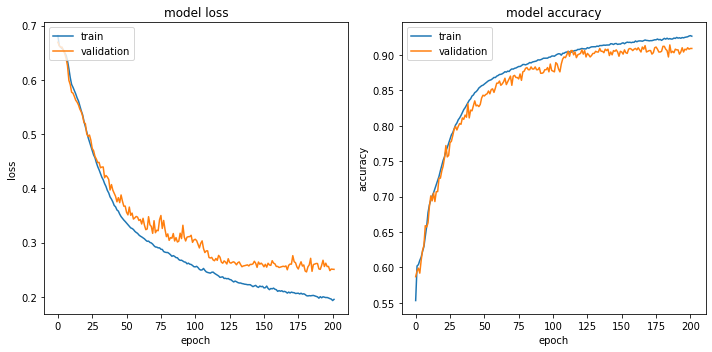

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(hist.history['loss'], label='training')
  ax1.plot(hist.history['val_loss'], label='validation')
  ax1.set_title('model loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(hist.history['accuracy'], label='training')
  ax2.plot(hist.history['val_accuracy'], label='validation')
  ax2.set_title('model accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()

In [ ]:
# def eval_model(model, x, true_label, ds_name="Training"):
#   loss, acc = model.evaluate(x, true_label, verbose=0)
#   print("{} Dataset: loss = {} and acccuracy = {}".format(ds_name, np.round(loss, 3), np.round(acc, 3)))

In [31]:
def eval_model2(model, ds, ds_name="Training"):
  loss, acc = model.evaluate(ds, verbose=0)
  print("{} Dataset: loss = {} and acccuracy = {}%".format(ds_name, np.round(loss, 3), np.round(acc*100, 2)))

In [32]:
eval_model2(model, xtrain_ds, "Training")
eval_model2(model, xval_ds, "Validation")
eval_model2(model, xtest_ds, "Test")

Training Dataset: loss = 0.191 and acccuracy = 92.64%
Validation Dataset: loss = 0.246 and acccuracy = 91.2%
Test Dataset: loss = 0.232 and acccuracy = 90.62%


In [ ]:
# def plotVec(ax, x, y, title="title"):
#   scatter = ax.scatter(x[:, 0], x[:, 1], c=y, 
#              cmap=matplotlib.colors.ListedColormap(["red", "blue", "yellow"]))
#   ax.set_title(title)
#   ax.legend(*scatter.legend_elements(), loc=0, title="Classes")